In [3]:
from tqdm.notebook import tqdm
import json
import pandas as pd

def read_data(path):
    sentence_a, sentence_b, labels = [], [], []
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f.readlines(), desc='Reading data'):
            line = json.loads(line)
            sentence_a.append(line['sentence1'])
            sentence_b.append(line['sentence2'])
            labels.append(int(line['label']))
    df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a', 'text_b', 'labels'])
    return df

In [4]:
train_df = read_data('data/train.json')

Reading data:   0%|          | 0/34334 [00:00<?, ?it/s]

In [5]:
train_df.head(5)

,text_a,text_b,labels
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [9]:
dev_df = read_data('data/dev.json')

Reading data:   0%|          | 0/4316 [00:00<?, ?it/s]

<AxesSubplot:>

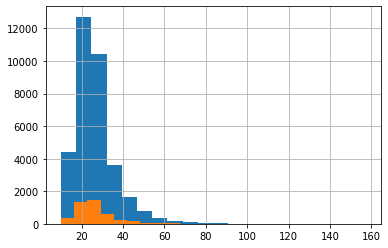

In [10]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).hist(bins=20)
(dev_df.text_a.str.len() + dev_df.text_b.str.len()).hist(bins=20)

In [11]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).quantile(0.99)

64.0

In [12]:
import torch
import random
import numpy as np

config = {
    'train_file_path': 'data/train.json',
    'dev_file_path': 'data/dev.json',
    'test_file_path': 'data/test.json',
    'embedding_file_path': '../NLP_Project/dataset/sgns.weibo.word.bz2',
        'train_val_ratio': 0.1,
        'vocab_size': 30000,
        'batch_size': 64,
        'max_seq_len':64,
        'num_epochs': 1,
        'learning_rate': 1e-3,
        'logging_step': 200,
        'seed': 2021
}
config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

seed_everything(config['seed'])

2021

In [13]:
from collections import Counter
import jieba
import bz2

def preprocess(config):
    
    def convert2df(file_path, dataset='train'):
        sentence_a, sentence_b, labels = [], [], []
        with open(file_path, 'r', encoding='utf8') as f:
            for line in tqdm(f.readlines(), desc=f'Reading {dataset} data'):
                line = json.loads(line)
                sentence_a.append(line['sentence1'])
                sentence_b.append(line['sentence2'])
                if dataset != 'test':
                    labels.append(int(line['label']))
                else:
                    labels.append(0)

                tokens = list(jieba.cut(sentence_a[-1])) + list(jieba.cut(sentence_b[-1]))
                token_counter.update(tokens)
        df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a', 'text_b', 'labels'])
        return df
    
    token_counter = Counter()
    
    train_df = convert2df(config['train_file_path'], 'train')
    dev_df = convert2df(config['dev_file_path'], 'dev')
    test_df = convert2df(config['test_file_path'], 'test')
    
    train_df = train_df.append(dev_df)
    vocab = set(token for token, _ in token_counter.most_common(config['vocab_size']))
    return train_df, test_df, vocab

In [14]:
train_df, test_df, vocab = preprocess(config)

Reading train data:   0%|          | 0/34334 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.789 seconds.
Prefix dict has been built successfully.


Reading dev data:   0%|          | 0/4316 [00:00<?, ?it/s]

Reading test data:   0%|          | 0/3861 [00:00<?, ?it/s]

In [20]:
# 词表对应成向量
def get_embedding(vocab, embedding_file_path):
    print('Processing embedding file...')
    token2embedding = {}
    
    with bz2.open(embedding_file_path) as f:
        token_vectors = f.readlines()
        meta_info = token_vectors[0].split()
        print(f'{int(meta_info[0])} tokens in embedding file in total, vector size is {int(meta_info[-1])}')
        
        for line in tqdm(token_vectors[1:]):
            line = line.split()
            token = line[0].decode('utf-8')
            vector = line[1:]
            if token in vocab:
                token2embedding[token] = [float(num) for num in vector]
    
    token2idx = {token: idx for idx, token in enumerate(token2embedding.keys(), 4)}
    UNK, PAD, BOS, EOS = '<unk>', '<pad>', '<bos>', '<eos>'
    token2idx[PAD] = 0
    token2idx[UNK] = 1
    token2idx[BOS] = 2
    token2idx[EOS] = 3
    
    idx2token = {idx: token for token, idx in token2idx.items()}
    idx2embedding = {token2idx[token]: embedding for token, embedding in token2embedding.items()}
    idx2embedding[0] = [.0] * int(meta_info[-1])
    idx2embedding[1] = [.0] * int(meta_info[-1])
    idx2embedding[2] = np.random.random(int(meta_info[-1])).tolist()
    idx2embedding[3] = np.random.random(int(meta_info[-1])).tolist()
    emb_mat = [idx2embedding[idx] for idx in range(len(idx2embedding))]

    return torch.tensor(emb_mat, dtype=torch.float), token2idx, len(vocab) + 4

In [21]:
embedding_matrix, token2idx, config['vocab_size'] = get_embedding(vocab, config['embedding_file_path'])

Processing embedding file...
195202 tokens in embedding file in total, vector size is 300


  0%|          | 0/195202 [00:00<?, ?it/s]

In [22]:
from collections import defaultdict

def tokenizer(sent, token2id):
    # not found -> 1 -> UNK
    ids = [token2id.get(token, 1) for token in jieba.cut(sent)]
    return ids

In [23]:
def read_data(data_df, train_val_ratio, token2id, mode='train'):
    if mode == 'train':
        X_train, y_train = defaultdict(list), []
        X_val, y_val = defaultdict(list), []
        num_val = int(len(data_df) * train_val_ratio)
    else:
        X_test, y_test = defaultdict(list), []
        
    for i, row in tqdm(data_df.iterrows(), desc=f'Precessing {mode} data', total=len(data_df)):
        text_left, text_right, label = row[0], row[1], row[2]
        
        inputs_a = tokenizer(text_left, token2id=token2idx)
        inputs_b = tokenizer(text_right, token2id=token2idx)
        
        if mode == 'train':
            if i<num_val:
                X_val['text_left'].append(inputs_a)
                X_val['text_right'].append(inputs_b)
                y_val.append(label)
            else:
                X_train['text_left'].append(inputs_a)
                X_train['text_right'].append(inputs_b)
                y_train.append(label)  

        else:
            X_test['text_left'].append(inputs_a)
            X_test['text_right'].append(inputs_b)
            y_test.append(label)
            
    if mode == 'train':
        label2id = {label: i for i, label in enumerate(np.unique(y_train))}
        id2label = {i: label for label, i in label2id.items()}
        y_train = torch.tensor([label2id[label] for label in y_train], dtype=torch.long)
        y_val = torch.tensor([label2id[label] for label in y_val], dtype=torch.long)
        return X_train, y_train, X_val, y_val, label2id, id2label
    else:
        y_test = torch.tensor(y_test, dtype=torch.long)
        return X_test, y_test

In [24]:
X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], token2idx, mode='train')
X_test, y_test = read_data(test_df, config['train_val_ratio'], token2idx, mode='test')

Precessing train data:   0%|          | 0/38650 [00:00<?, ?it/s]

Precessing test data:   0%|          | 0/3861 [00:00<?, ?it/s]

In [25]:
from torch.utils.data import Dataset

class AFQMCDataset(Dataset):
    def __init__(self, x, y):
        super(AFQMCDataset, self).__init__()
        self.x = x
        self.y = y
        
    def __getitem__(self, idx):
        example = (self.x['text_left'][idx], self.x['text_right'][idx], self.y[idx])
        return example
    
    def __len__(self):
        return self.y.size(0)

In [27]:
# 假设 传入 Collator一共两条数据
# 每条数据 data = (sentence1, sentence2, label])
datas = [([1,2,3],[4,5,6],1),([777,888,999],[321,543,654],0)]
print(*datas)
print(zip(*datas))
print(list(zip(*datas)))

([1, 2, 3], [4, 5, 6], 1) ([777, 888, 999], [321, 543, 654], 0)
[([1, 2, 3], [777, 888, 999]), ([4, 5, 6], [321, 543, 654]), (1, 0)]


In [28]:
"""
从 AFQMCDataset输出的example=(sent1, sent2, label)
1. 将sent1, sent2, label分别放在一起
2. 对齐操作, 按sent1, sent2中最长的句子
3. 放入tensor
"""
class Collator:
    def __init__(self, max_seq_len):
        self.max_seq_len = max_seq_len
        
    def get_max_seq_len(self, ids_list):
        cur_max_seq_len = max(len(input_id) for input_id in ids_list)
        max_seq_len = min(self.max_seq_len, cur_max_seq_len)
        return max_seq_len
    
    @staticmethod
    def pad_and_truncate(text_ids_list, max_seq_len):
        input_ids = torch.zeros((len(text_ids_list), max_seq_len), dtype=torch.long)
        for i, text_ids in enumerate(text_ids_list):
            seq_len = min(len(text_ids), max_seq_len)
            input_ids[i, :seq_len] = torch.tensor(text_ids[:seq_len], dtype=torch.long)
        
        return input_ids
    
    def __call__(self, examples):
        # step 1
        text_ids_left_list, text_ids_right_list, labels_list = list(zip(*examples))
        # step 2.1
        max_text_left_length = self.get_max_seq_len(text_ids_left_list)
        max_text_right_length = self.get_max_seq_len(text_ids_right_list)
        # step 2.2
        text_left_ids = self.pad_and_truncate(text_ids_left_list, max_text_left_length)
        text_right_ids = self.pad_and_truncate(text_ids_right_list, max_text_right_length)
        labels = torch.tensor(labels_list, dtype=torch.long)
        
        data_list = [text_left_ids, text_right_ids, labels]
        return data_list

In [29]:
from torch.utils.data import DataLoader

def build_dataloader(train_df, test_df, config, vocab):
    X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], vocab, mode='train')
    X_test, y_test = read_data(test_df, config['train_val_ratio'], vocab, mode='test')

    train_dataset = AFQMCDataset(X_train, y_train)
    val_dataset = AFQMCDataset(X_val, y_val)
    test_dataset = AFQMCDataset(X_test, y_test)
    
    collate_fn = Collator(config['max_seq_len'])

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'],
                                  num_workers=4, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'],
                                num_workers=4, shuffle=False, collate_fn=collate_fn)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'],
                                 num_workers=4, shuffle=False, collate_fn=collate_fn)

    return id2label, test_dataloader, train_dataloader, val_dataloader

In [30]:
id2label, test_dataloader, train_dataloader, val_dataloader = build_dataloader(train_df, test_df, config, token2idx)

Precessing train data:   0%|          | 0/38650 [00:00<?, ?it/s]

Precessing test data:   0%|          | 0/3861 [00:00<?, ?it/s]

In [31]:
for i in train_dataloader:
    print(i)
    break

[tensor([[ 128,    1,  410,  ...,    0,    0,    0],
        [ 272, 1359, 2930,  ...,    0,    0,    0],
        [ 272, 1359, 3507,  ...,    0,    0,    0],
        ...,
        [ 286,  894,   61,  ...,    0,    0,    0],
        [ 746, 1313,  272,  ...,    0,    0,    0],
        [ 117,   22,  286,  ...,    0,    0,    0]]), tensor([[ 410,  272, 1359, 4472, 3341,   20,  260,    0,    0,    0,    0,    0,
            0,    0],
        [ 190, 3951,  272, 1359,  453, 2844,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  60, 1191,    1,   69, 1310,  272, 1359, 4369,   45,   88,    0,    0,
            0,    0],
        [ 272, 1359,   85,   45,  648,    4, 1448, 1359,  449,  180,   86,    0,
            0,    0],
        [2493, 1448, 1359,   61,   20, 4369, 4101,   88,    0,    0,    0,    0,
            0,    0],
        [ 272, 1359, 2076,   89,   16,  220,    0,    0,    0,    0,    0,    0,
            0,    0],
        [  22,    5, 1663, 3075,  378, 1090, 1090, 109

In [32]:
from sklearn.metrics import f1_score, accuracy_score

def evaluation(config, model, val_dataloader):
    model.eval()
    preds, labels = [], []
    val_loss = 0.
    val_iterator = tqdm(val_dataloader, desc='Evaluation', total=len(val_dataloader))
    with torch.no_grad():
        for batch in val_iterator:
            # batch [([sent_left_id1], [sent_left_id1],...), ([sent_right_id1], [sent_right_id2], ...), ([label], [label], ...)]
            labels.append(batch[-1])
            batch = [item.to(config['device']) for item in batch]
            loss, logits = model(batch)[:2]
            val_loss += loss.item()
            preds.append(logits.argmax(dim=-1).detach().cpu())
            
    avg_val_loss = val_loss / len(val_dataloader)
    labels = torch.cat(labels, dim=0).numpy()
    preds = torch.cat(preds, dim=0).numpy()
    f1 = f1_score(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return avg_val_loss, f1, acc

In [33]:
from tqdm.notebook import trange
from torch.optim import AdamW

def train(model, config, id2label, train_dataloader, val_dataloader):
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
    model.to(config['device'])
    epoch_iterator = trange(config['num_epochs'])
    
    global_steps, train_loss, logging_loss = 0, 0., 0.
    
    for epoch in epoch_iterator:
        train_iterator = tqdm(train_dataloader, desc='Training', total=len(train_dataloader))
        model.train()
        for batch in train_iterator:
            batch = [item.to(config['device']) for item in batch]
            loss = model(batch)[0]
            
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            global_steps += 1
            
            if global_steps % config['logging_step'] == 0:
                print_train_loss = (train_loss - logging_loss) / config['logging_step']
                logging_loss = train_loss
                avg_val_loss, f1, acc = evaluation(config, model, val_dataloader)
                
                print_log = f'>>> training loss: {print_train_loss:.4f}, valid loss: {avg_val_loss:.4f}, ' \
                            f'valid f1 score: {f1:.4f}, valid acc: {acc:.4f}'
                print(print_log)
                model.train()

    return model    

In [34]:
def predict(config, id2label, model, test_dataloader):
    test_iterator = tqdm(test_dataloader, desc='Predicting', total=len(test_dataloader))
    model.eval()
    test_preds = []
    with torch.no_grad():
        for batch in test_iterator:
            batch = [item.to(config['device']) for item in batch]
            logits = model(batch)[1]
            test_preds.append(logits.argmax(dim=-1).detach().cpu())
    test_preds = torch.cat(test_preds, dim=0).numpy()
    test_preds = [id2label[id_] for id_ in test_preds]
    return test_preds

In [35]:
# 定义一个 [2, 3, 4] -> [batch_size, seq_len, embedding_dim] 表示1个batch2个句子, 每个句子3个词每个词维度4
a = torch.tensor([[[5., 5., 5., 5.],[6., 6., 6., 6.],[7., 7., 7., 7.]], [[1., 1., 1., 1.],[2., 2., 2., 2.],[3., 3., 3., 3.]]])
a.shape

torch.Size([2, 3, 4])

In [36]:
# [2, 1, 4]
ones = torch.ByteTensor([[[1, 1, 0, 0]],[[0, 1, 1, 0]]])
ones.shape

torch.Size([2, 1, 4])

In [38]:
# 将词向量某些维度清0
print(a)
print(ones * a) # ones broadcast [2, 3, 4]
print((ones * a).shape)

tensor([[[5., 5., 5., 5.],
         [6., 6., 6., 6.],
         [7., 7., 7., 7.]],

        [[1., 1., 1., 1.],
         [2., 2., 2., 2.],
         [3., 3., 3., 3.]]])
tensor([[[5., 5., 0., 0.],
         [6., 6., 0., 0.],
         [7., 7., 0., 0.]],

        [[0., 1., 1., 0.],
         [0., 2., 2., 0.],
         [0., 3., 3., 0.]]])
torch.Size([2, 3, 4])


#### masked_fill

In [42]:
# [2, 3, 1]
mask = torch.BoolTensor([[[1], [1], [0]], [[0], [1], [1]]])
mask.shape

torch.Size([2, 3, 1])

In [40]:
# 定义一个 [2, 3, 4] -> [batch_size, seq_len, embedding_dim] 表示1个batch2个句子, 每个句子3个词每个词维度4
a = torch.tensor([[[5., 5., 5., 5.],[6., 6., 6., 6.],[7., 7., 7., 7.]], [[1., 1., 1., 1.],[2., 2., 2., 2.],[3., 3., 3., 3.]]])
a.shape

torch.Size([2, 3, 4])

In [44]:
# a [2, 3, 4]  mask [2, 3, 1] 可以广播
# 将mask中为True的元素所在的索引, 在a中相同索引处替换为value
b = a.masked_fill(mask, value=torch.tensor(-1e7))
print(a)
print(b)
print(b.shape)

tensor([[[5., 5., 5., 5.],
         [6., 6., 6., 6.],
         [7., 7., 7., 7.]],

        [[1., 1., 1., 1.],
         [2., 2., 2., 2.],
         [3., 3., 3., 3.]]])
tensor([[[-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [ 7.0000e+00,  7.0000e+00,  7.0000e+00,  7.0000e+00]],

        [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07],
         [-1.0000e+07, -1.0000e+07, -1.0000e+07, -1.0000e+07]]])
torch.Size([2, 3, 4])


In [47]:
# [2, 1, 4]
ones = torch.BoolTensor([[[1, 1, 0, 0]], [[0, 1, 1, 0]]])
ones.shape

torch.Size([2, 1, 4])

In [48]:
mask = ones
b = a.masked_fill(mask, value=torch.tensor(-1e7))
print(b)
print(b.shape)

tensor([[[-1.0000e+07, -1.0000e+07,  5.0000e+00,  5.0000e+00],
         [-1.0000e+07, -1.0000e+07,  6.0000e+00,  6.0000e+00],
         [-1.0000e+07, -1.0000e+07,  7.0000e+00,  7.0000e+00]],

        [[ 1.0000e+00, -1.0000e+07, -1.0000e+07,  1.0000e+00],
         [ 2.0000e+00, -1.0000e+07, -1.0000e+07,  2.0000e+00],
         [ 3.0000e+00, -1.0000e+07, -1.0000e+07,  3.0000e+00]]])
torch.Size([2, 3, 4])


#### ESIM

In [49]:
model_config = {
    'embedding': embedding_matrix,
    'freeze_emb': True,
    'hidden_size': 256,
    'dropout': 0.3,
    'num_layers': 2,
    'concat_layers': True,
    'rnn_type': 'lstm',
    'num_labels': len(id2label)
}

In [52]:
import torch.nn as nn
import torch.nn.functional as F

In [53]:
class RNNDropout(nn.Dropout):
    # 将词向量某些维度清0 [B, L, D]
    def forward(self, sequence_batch):
        # ones [B, D]
        ones = sequence_batch.data.new_ones(sequence_batch.shape[0], sequence_batch.shape[-1])
        # 随机mask [B, D]
        dropout_mask = F.dropout(ones, self.p, self.training, inplace=False)
        
        return dropout_mask.unsqueeze(1) * sequence_batch

In [54]:
class StackedBRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,
                 dropout_rate=0, dropout_output=False, rnn_type=nn.LSTM,
                 concat_layers=False):
        super(StackedBRNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout_output = dropout_output
        self.num_layers = num_layers
        self.concat_layers = concat_layers
        self.rnns = nn.ModuleList()
        for i in range(num_layers):
            input_size = input_size if i == 0 else 2 * hidden_size
            self.rnns.append(rnn_type(input_size, hidden_size, num_layers=1, bidirectional=True))
            
    def forward(self, x):
        # x [B, L, D] -> [L, B, D]
        x = x.transpose(0, 1)
        outputs = [x]
        for i in range(self.num_layers):
            rnn_input = outputs[-1]
            if self.dropout_rate > 0:
                rnn_input = F.dropout(rnn_input, p=self.dropout_rate, training=self.training)
            # self.rnn[i](rnn_input) (output, (h_n, c_n))
            rnn_output = self.rnns[i](rnn_input)[0]
            outputs.append(rnn_output)
            
        # outputs: [x, output0, output1]
        if self.concat_layers:
            output = torch.cat(outputs[1:], 2)
        else:
            output = output[-1]
        
        # output [L, B, D] -> [B, L, D]
        output = output.transpose(0, 1)
        if self.dropout_output and self.dropout_rate:
            output = F.dropout(output, p=self.dropout_rate, training=self.training)
            
        return output.contiguous()

In [70]:
class BidirectionalAttention(nn.Module):
    def __init__(self):
        super(BidirectionalAttention, self).__init__()

    def forward(self, v1, v1_mask, v2, v2_mask):
        # v1(a) [B, L, H]  v1_mask [B, L]
        # v2(b) [B, R, H]  v2_mask [B, R]
        # step 1 计算矩阵相似度 similarity_matrix [B, L, R]
        similarity_matrix = v1.bmm(v2.transpose(2, 1).contiguous())
        # step 2 mask step 3 softmax
        # 将similarity_matxrix v1中pad对应的权重给mask
        # [B, L, R]
        v2_v1_attn = F.softmax(similarity_matrix.masked_fill(v1_mask.unsqueeze(2), -1e7), dim=1)
        # 将similarity_matxrix v2中pad对应的权重给mask
        # [B, L, R]
        v1_v2_attn = F.softmax(similarity_matrix.masked_fill(v2_mask.unsqueeze(1), -1e7), dim=2)
        # 计算attention
        # [B, L, R] @ [B, R, H]
        # 句子a对句子b的影响 [B, L, H]
        attented_v1 = v1_v2_attn.bmm(v2)
        # [B, L, R] -> [B, R, L] @ [B, L, H]
        # 句子b对句子a的影响 [B, R, H]
        attented_v2 = v2_v1_attn.transpose(1, 2).bmm(v1)
        
        # attented_v1将v1对应的pad填充为0
        # attented_v2将v2对应的pad填充为0
        attented_v1.masked_fill(v1_mask.unsqueeze(2), 0)
        attented_v2.masked_fill(v2_mask.unsqueeze(2), 0)
        
        return attented_v1, attented_v2

In [71]:
class ESIM(nn.Module):
    def __init__(self, config):
        super(ESIM, self).__init__()
        rnn_mapping = {'lstm': nn.LSTM, 'gru': nn.GRU}
        self.embedding = nn.Embedding.from_pretrained(config['embedding'], freeze=config['freeze_emb'])
        self.rnn_dropout = RNNDropout(p=config['dropout'])
        
        rnn_size = config['hidden_size']
        if config['concat_layers']:
            rnn_size //= config['num_layers']
            
        self.input_encoding = StackedBRNN(input_size=config['embedding'].size(1),
                                          hidden_size=rnn_size // 2,
                                          num_layers=config['num_layers'],
                                          rnn_type=rnn_mapping[config['rnn_type']],
                                          concat_layers=config['concat_layers'])
        
        self.attention = BidirectionalAttention()
        
        self.projection = nn.Sequential(nn.Linear(4 * config['hidden_size'],
                                        config['hidden_size']), nn.ReLU())
        
        self.composition = StackedBRNN(input_size=config['hidden_size'],
                                       hidden_size=rnn_size // 2,
                                       num_layers=config['num_layers'],
                                       rnn_type=rnn_mapping[config['rnn_type']],
                                       concat_layers=config['concat_layers'])
        
        self.classification = nn.Sequential(nn.Dropout(p=config['dropout']),
                                            nn.Linear(4 * config['hidden_size'], config['hidden_size']),
                                            nn.Tanh(),
                                            nn.Dropout(p=config['dropout']))
        self.out = nn.Linear(config['hidden_size'], config['num_labels'])
        
    def forward(self, inputs):
        # inputs: [sent1_tensor, sent2_tensor, labels_tensor]
        # B: batch_size  L: inputs_left seq_len  R: inputs_right seq_len  D: embedding_size  H: hidden_size
        # query: sent1_tensor [B, L]  doc: sent2_tensor [B, R]
        query, doc = inputs[0].long(), inputs[1].long()
        # 判断query和doc中的每一个数是不是0 query: [2, 3, 4, 5, 0, 0, 0] -> query_mask: [0, 0, 0, 0, 1, 1, 1]
        query_mask, doc_mask = (query == 0), (doc == 0)
        # query [B, L, D]  doc [B, R, D]
        query, doc = self.embedding(query), self.embedding(doc)
        # query [B, L, D]  doc [B, R, D]
        query, doc = self.rnn_dropout(query), self.rnn_dropout(doc)
        # query [B, L, H]  doc [B, R, H]
        query, doc = self.input_encoding(query), self.input_encoding(doc)
        # 1. 计算矩阵相似度 2. mask操作 3. 进行softmax 4. 计算attention
        # query [B, L, H]  query_mask [B, L]
        # doc [B, R, H]  doc_mask [B, R]
        attended_query, attened_doc = self.attention(query, query_mask, doc, doc_mask)
        # Enhanced 拼接
        # enhanced_query [B, L, 4 * h]
        # enhanced_doc [B, R, 4 * h]
        enhanced_query = torch.cat([query,
                                    attended_query,
                                    query - attended_query,
                                    query * attended_query], dim=-1)
        enhanced_doc = torch.cat([doc,
                                  attened_doc,
                                  doc - attened_doc,
                                  doc * attened_doc], dim=-1)
        # projected_query [B, L, H]
        # projected_doc [B, R, H]
        projected_query, projected_doc = self.projection(enhanced_query), self.projection(enhanced_doc)
        # query [B, L, H]
        # doc [B, R, H]
        query, doc = self.composition(projected_query), self.composition(projected_doc)
        # pooling
        # query_mask, doc_mask 判断query和doc中的每一个数是不是0 如果是1表示该位置是pad
        # reversed_query_mask 0代表pad
        # reversed_query_mask [B, L]  reversed_doc_mask [B, R]
        reversed_query_mask, reversed_doc_mask = 1. - query_mask.float(), 1. - doc_mask.float()
        
        query_avg = torch.sum(query * reversed_query_mask.unsqueeze(2), dim=1) / (torch.sum(reversed_doc_mask, dim=1, keepdim=True) + 1e-8)
        doc_avg = torch.sum(doc * reversed_doc_mask.unsqueeze(2), dim=1) / (torch.sum(reversed_doc_mask, dim=1, keepdim=True) + 1e-8)
            
        # 防止pad影响
        query = query.masked_fill(query_mask.unsqueeze(2), -1e7)
        doc = doc.masked_fill(doc_mask.unsqueeze(2), -1e7)
        
        query_max, _ = query.max(dim=1)
        doc_max, _ = doc.max(dim=1)
        
        # v [B, 4 * H]
        v = torch.cat([query_avg, query_max, doc_avg, doc_max], dim=-1)
        
        # hidden [B, H]
        hidden = self.classification(v)
        out = self.out(hidden)
        outputs = (out,)
        if len(inputs) == 3:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(out, inputs[-1])
            outputs = (loss,) + outputs
            
        return outputs

In [72]:
model = ESIM(model_config)

In [73]:
best_model = train(model, config, id2label, train_dataloader, val_dataloader)

  0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/484 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

>>> training loss: 0.6162, valid loss: 0.6374, valid f1 score: 0.3992, valid acc: 0.6644


Evaluation:   0%|          | 0/121 [00:00<?, ?it/s]

>>> training loss: 0.6095, valid loss: 0.6390, valid f1 score: 0.3992, valid acc: 0.6644
